# 1. Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import joblib

# 2. Load & Visualize Data

In [35]:
data = pd.read_csv("data/Test Macine Learning Enginer Inosoft_AMZN.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6516 entries, 0 to 6515
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6516 non-null   object 
 1   Open       6516 non-null   float64
 2   High       6516 non-null   float64
 3   Low        6516 non-null   float64
 4   Close      6516 non-null   float64
 5   Adj Close  6516 non-null   float64
 6   Volume     6516 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 356.5+ KB


In [37]:
# Ubah kolom Date menjadi datetime
data['Date'] = pd.to_datetime(data['Date'])

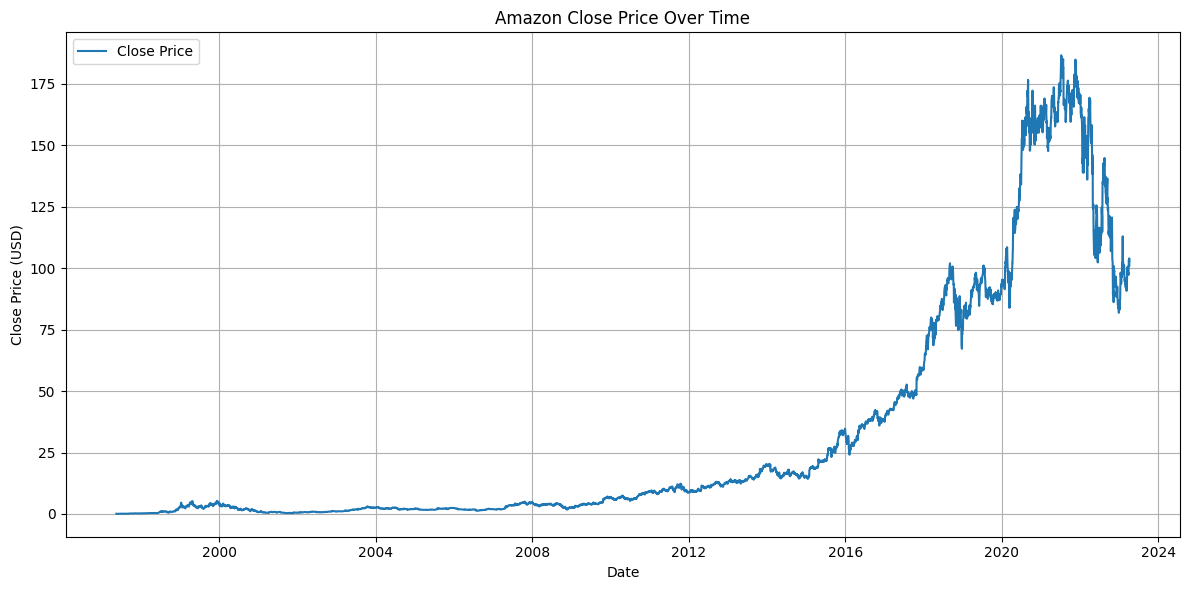

In [38]:
# Plot Close price terhadap waktu
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'], label='Close Price')
plt.title('Amazon Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

The AMZN stock remained below 5 until 2009, began increasing steadily to 25 by 2016, and surged to 180 during the COVID-19 pandemic before correcting to under 100 in 2023

# 3. Preprocessing 

In [39]:
close_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(close_prices)

# 4. Train/Test Split 

In [40]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [41]:
#choosing /initializing hypermeters
data_dim = 1
hidden_dim = 32
output_dim = 1
num_layers = 1
learning_rate = 0.001
epochs = 60
SEQ_LENGTH = 60
n_splits = 5

In [42]:
X, y = create_sequences(scaled_close, SEQ_LENGTH)
tscv = TimeSeriesSplit(n_splits=n_splits)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

The dataset is divided into 80% training data and 20% testing data. Furthermore, the training data (80%) will be split back into training data and validation data during the cross-validation process

# 6. Define RNN Model

Recurrent Neural Network (RNN) is a type of artificial neural network designed to process sequential data, such as text, voice, or time series data. Unlike regular feedforward networks, RNNs have a feedback mechanism that allows information from previous times to be used to influence the current output. This makes RNNs particularly suitable for understanding context in sequential data. In its development, RNN is divided into three main types, namely Simple RNN, Long Short-Term Memory (LSTM), and Gated Recurrent Unit (GRU). All three are designed to overcome various challenges in data sequence processing, especially related to the limitations in remembering long-term information.

In [43]:
# Simple RNN
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x, _ = self.rnn(x)  # PyTorch handles initial hidden state internally if not provided
        x = self.fc(x[:, -1])  # Use the last time step's output
        return x

Long Short-Term Memory (LSTM) is a variant of RNN developed to overcome the weakness of Simple RNN in storing information over time. LSTM uses a more complex structure with memory cells and three main gates-input gate, forget gate, and output gate-that regulate which information is stored, forgotten, or output. This architecture allows LSTMs to handle long-term dependencies more effectively, making them popular in applications such as language translation, sentiment analysis, and text processing.

In [44]:
# LSTM
class LSTM(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(LSTM, self).__init__()
         # Define the LSTM layer
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        # Define the output layer
        self.fc = torch.nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        # Forward pass through LSTM layer
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x

Gated Recurrent Unit (GRU) is another variant of RNN that offers similar performance to LSTM but with a simpler architecture. GRU uses only two gates, namely update gate and reset gate, which serve to control the flow of information without using separate memory cells as in LSTM. Due to the simplicity of its structure, GRU is often faster in training and requires less computational resources, making it an efficient choice for many sequential tasks such as text classification or time series prediction.

In [45]:
# GRU
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(GRU, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x, _ = self.gru(x)            # x: [batch, seq_len, hidden_dim]
        x = self.fc(x[:, -1])         # Use the last time step's output
        return x

# 7. Training Model

In [46]:
# Konversi ke tensor
X_train_tensor = torch.tensor(X_train_full, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_full, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Bungkus dengan TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Buat DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [47]:
models = {
    "RNN": RNN(data_dim, hidden_dim, output_dim, num_layers),
    "LSTM": LSTM(data_dim, hidden_dim, output_dim, num_layers),
    "GRU": GRU(data_dim, hidden_dim, output_dim, num_layers)
}

In the case of stock forecasting, the selection of evaluation metrics such as RMSE (Root Mean Squared Error), MAE (Mean Absolute Error), and MAPE (Mean Absolute Percentage Error) is important to provide an overall picture of the model's accuracy. RMSE is used because it penalizes larger prediction errors, thus helping to identify models that are more sensitive to outliers, which are common in stock price movements. MAE is used because it is easy to interpret and shows the average absolute error without taking into account the direction of the error, providing a consistent overview of model performance. Meanwhile, MAPE provides a perspective of the error as a percentage relative to the actual value, which is useful for comparing the accuracy of the model across different scales of stock prices. The combination of these three metrics provides a balanced evaluation of absolute error, sensitivity to outliers, and relative scale of error.

In [48]:
def evaluate_model(model, test_loader, scaler):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            predictions.extend(output.numpy())
            actuals.extend(y_batch.numpy())

    predicted = scaler.inverse_transform(np.array(predictions))
    actual = scaler.inverse_transform(np.array(actuals))

    rmse = root_mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    mape = mean_absolute_percentage_error(actual, predicted) * 100

    return rmse, mae, mape

In [49]:
loss_history = {}
metrics_history = {}
for model_name, model in models.items():
    print(f"\nTraining {model_name} model...")
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []  # Simpan loss per epoch

    for epoch in range(epochs):
        model.train()
        batch_losses = []

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())

        epoch_loss = np.mean(batch_losses)
        train_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}")
        
    loss_history[model_name] = train_losses
    rmse, mae, mape = evaluate_model(model, test_loader, scaler)
    metrics_history[model_name] = {
        'RMSE': rmse, 
        'MAE': mae, 
        'MAPE': mape
        }


Training RNN model...
Epoch 1/60, Loss: 0.00039235871590341206
Epoch 2/60, Loss: 0.008418012268224978
Epoch 3/60, Loss: 0.005801209997105302
Epoch 4/60, Loss: 0.005116196849907041
Epoch 5/60, Loss: 0.004108129436602852
Epoch 6/60, Loss: 0.0033145654762390146
Epoch 7/60, Loss: 0.00249410906687857
Epoch 8/60, Loss: 0.001632405493772374
Epoch 9/60, Loss: 0.0008063437240275281
Epoch 10/60, Loss: 0.00023714751413985685
Epoch 11/60, Loss: 4.006354797763342e-06
Epoch 12/60, Loss: 4.72009053331942e-06
Epoch 13/60, Loss: 3.6908677160587653e-06
Epoch 14/60, Loss: 5.3631321367799116e-06
Epoch 15/60, Loss: 3.794804930888098e-06
Epoch 16/60, Loss: 6.806724111342708e-06
Epoch 17/60, Loss: 4.223602529600331e-06
Epoch 18/60, Loss: 9.995695613177438e-06
Epoch 19/60, Loss: 5.945708644922919e-06
Epoch 20/60, Loss: 1.6401430801378702e-05
Epoch 21/60, Loss: 1.1652610452912356e-05
Epoch 22/60, Loss: 2.759837254895507e-05
Epoch 23/60, Loss: 2.579580203693953e-05
Epoch 24/60, Loss: 3.940705196478934e-05
Epoc

# 8. Evaluation

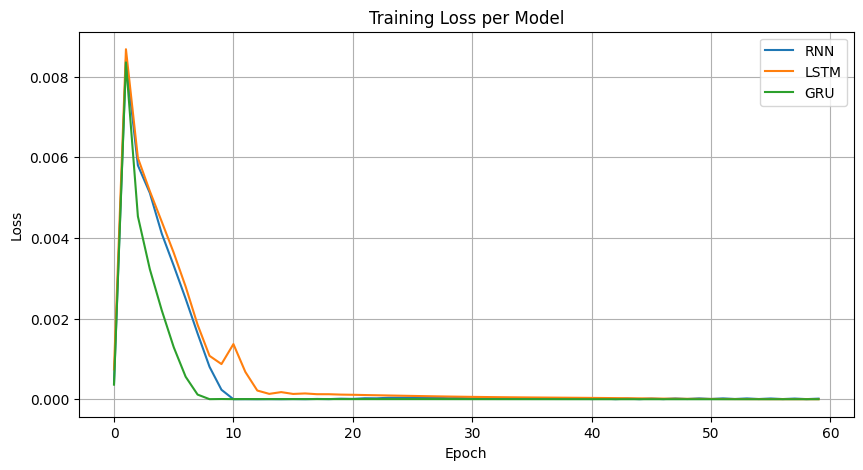

In [50]:
plt.figure(figsize=(10, 5))
for name, losses in loss_history.items():
    plt.plot(losses, label=name)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Model")
plt.legend()
plt.grid(True)
plt.show()

All models show comparable loss values; however, a deeper evaluation requires considering RMSE, MAE, and MAPE to gain a more comprehensive understanding of model performance.

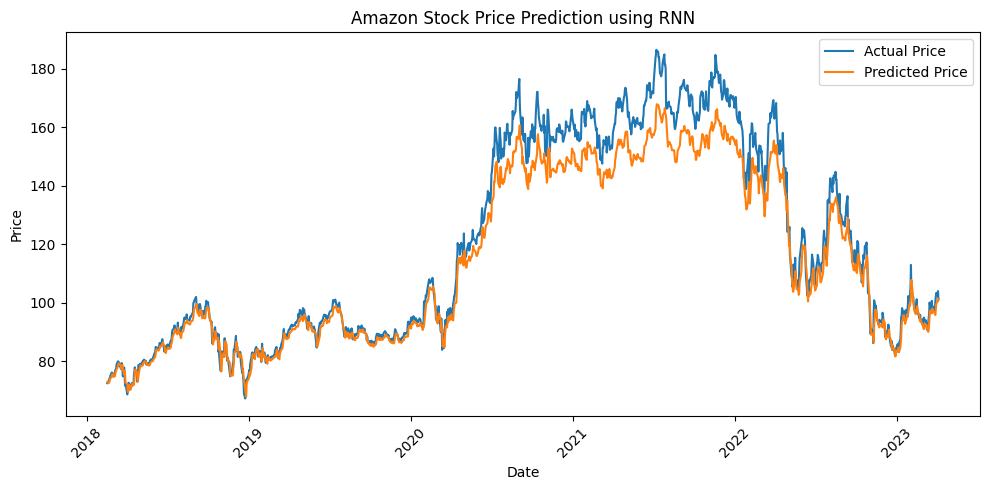

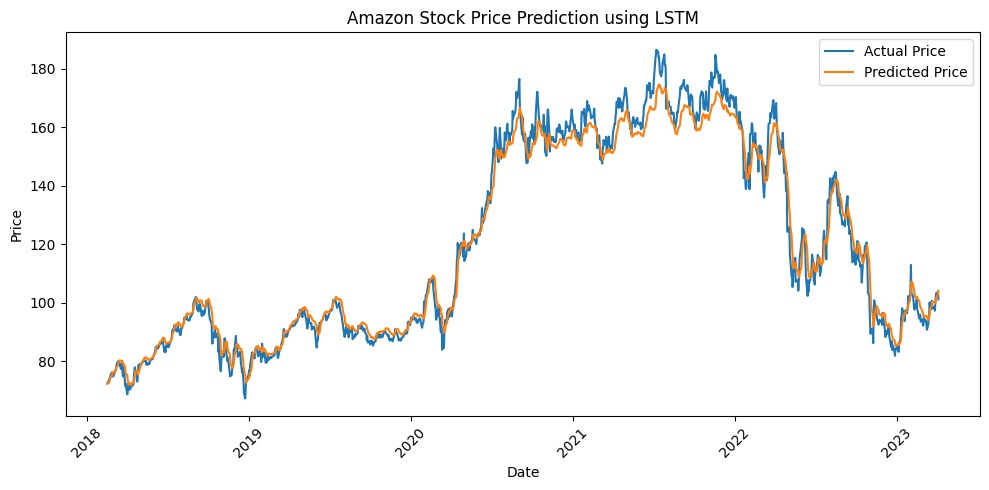

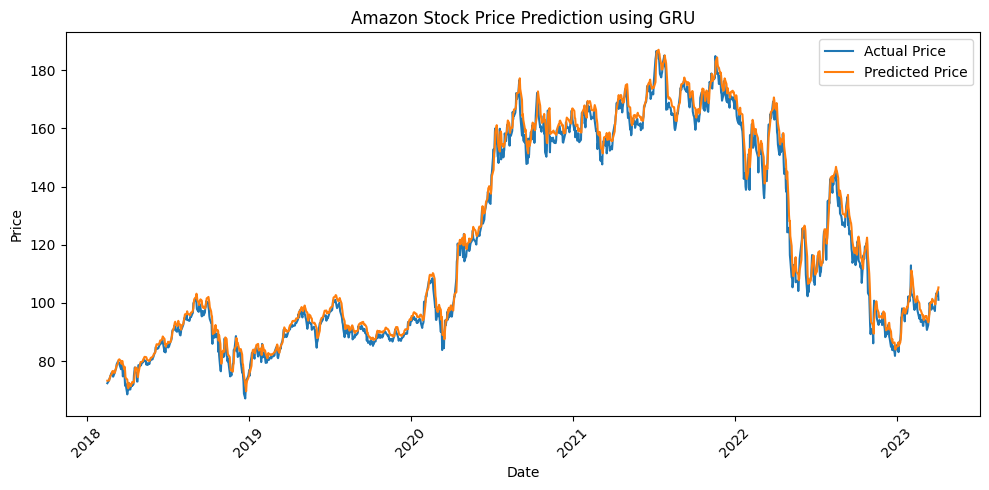

In [51]:
for model_name, model in models.items():
    # Validation
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            predictions.extend(output.numpy())
            actuals.extend(y_batch.numpy())

    predicted = scaler.inverse_transform(np.array(predictions))
    actual = scaler.inverse_transform(np.array(actuals))
    
    dates_to_plot = data['Date'].iloc[-len(actual):]
    plt.figure(figsize=(10,5))
    plt.plot(dates_to_plot, actual, label='Actual Price')
    plt.plot(dates_to_plot, predicted, label='Predicted Price')
    plt.title(f'Amazon Stock Price Prediction using {model_name}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)  # agar tanggalnya tidak saling menimpa
    plt.tight_layout()       # agar layout tidak terpotong
    plt.show()
    

Of the three models, the GRU model shows the closest predicted value to the actual value in the dataset, indicating its better ability to capture the temporal patterns and dynamics of data movement compared to the other models.

Model: RNN
RMSE: 8.1355
MAE: 5.9905
MAPE: 4.2374

Model: LSTM
RMSE: 4.6619
MAE: 3.4812
MAPE: 2.8172

Model: GRU
RMSE: 3.6198
MAE: 2.7247
MAPE: 2.3212



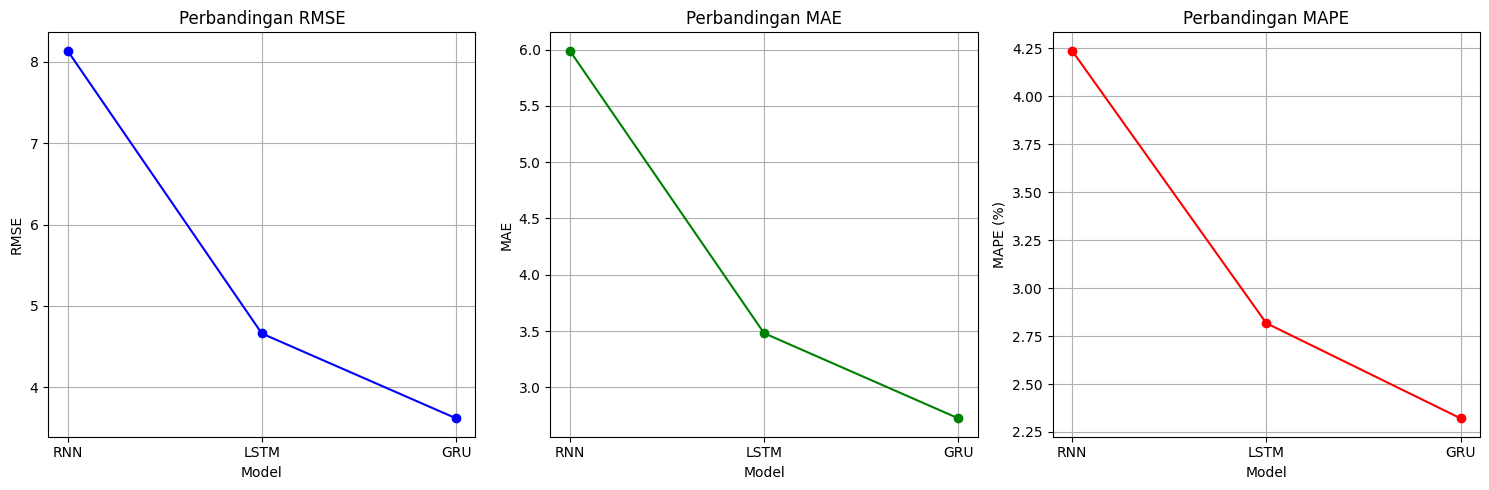

In [52]:
# Print evaluation metrics
for name, metrics in metrics_history.items():
    print(f"Model: {name}")
    print(f"RMSE: {metrics['RMSE']:.4f}")
    print(f"MAE: {metrics['MAE']:.4f}")
    print(f"MAPE: {metrics['MAPE']:.4f}")
    print()

# Ambil nama model
models = list(metrics_history.keys())

# Ambil nilai metrik
rmse_values = [metrics_history[model]['RMSE'] for model in models]
mae_values = [metrics_history[model]['MAE'] for model in models]
mape_values = [metrics_history[model]['MAPE'] for model in models]

# Buat 3 grafik line dalam 1 figure
plt.figure(figsize=(15, 5))

# Grafik 1: RMSE
plt.subplot(1, 3, 1)
plt.plot(models, rmse_values, marker='o', linestyle='-', color='blue')
plt.title('Perbandingan RMSE')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.grid(True)

# Grafik 2: MAE
plt.subplot(1, 3, 2)
plt.plot(models, mae_values, marker='o', linestyle='-', color='green')
plt.title('Perbandingan MAE')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.grid(True)

# Grafik 3: MAPE
plt.subplot(1, 3, 3)
plt.plot(models, mape_values, marker='o', linestyle='-', color='red')
plt.title('Perbandingan MAPE')
plt.xlabel('Model')
plt.ylabel('MAPE (%)')
plt.grid(True)

plt.tight_layout()
plt.show()


The GRU model has the smallest values in all RMSE, MAE, and MAPE metrics, which indicates that it provides the most accurate and consistent predictions compared to other models, so it can be considered as the best model for this stock forecasting case.

# 9. Evaluation With Cross Validation

To further analyze the training results, Cross Validation with the TimeSeriesSplit method will be used because this method is very suitable for time series data that pays great attention to time sequence. Unlike the usual k-fold which splits the data randomly, TimeSeriesSplit keeps the chronological order of the data so that the model is trained and tested gradually in time order, preventing future data leakage into the past and providing a more realistic evaluation of the model's performance in the real world.

From the 80% training data, we further divide it using TimeSeriesSplit cross-validation, which respects the temporal order of the data to prevent data leakage. In each split, earlier data is used for training while later data is reserved for validation. This approach simulates a real-world scenario where future data should never influence past predictions, ensuring that the model evaluation is both realistic and reliable. By maintaining the chronological sequence, TimeSeriesSplit provides a robust evaluation method that preserves the integrity of time series modeling.


===== Summary of Results =====

Model: RNN
Train RMSE: 0.0036
Train MAE: 0.0034
Train MAPE: 1.1800
Validation RMSE: 0.0035
Validation MAE: 0.0029
Validation MAPE: 0.3137

Model: LSTM
Train RMSE: 0.0029
Train MAE: 0.0024
Train MAPE: 0.9686
Validation RMSE: 0.0048
Validation MAE: 0.0040
Validation MAPE: 0.4124

Model: GRU
Train RMSE: 0.0015
Train MAE: 0.0013
Train MAPE: 0.3892
Validation RMSE: 0.0024
Validation MAE: 0.0018
Validation MAPE: 0.0841


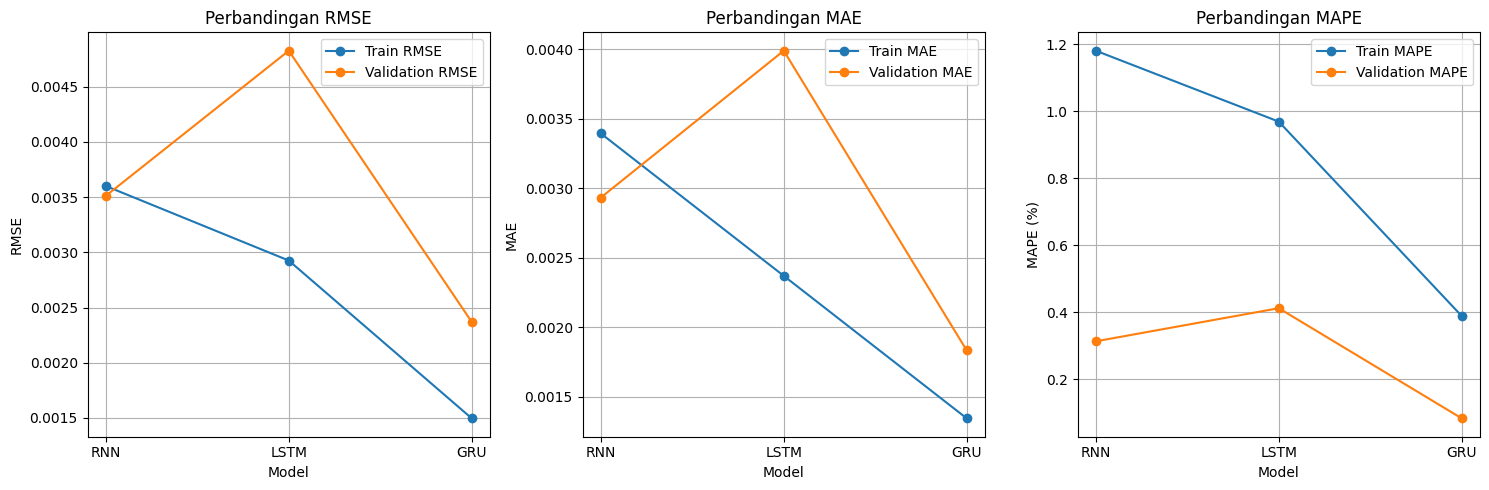

In [ ]:
# ========== Cross-Validation Setup ==========
tscv = TimeSeriesSplit(n_splits=n_splits)
models = {
    "RNN": RNN,
    "LSTM": LSTM,
    "GRU": GRU
}

train_losses_all = []
validation_losses_all = []
results = {}

# ========== Evaluation Loop ==========
for model_name, model_class in models.items():

    fold_results = {
        'Train RMSE': [],
        'Train MAE': [],
        'Train MAPE': [],
        'Validation RMSE': [],
        'Validation MAE': [],
        'Validation MAPE': []
    }

    for train_idx, val_idx in tscv.split(X_train_full):

        X_train, X_val = X_train_full[train_idx], X_train_full[val_idx]
        y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

        train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=False)
        val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64, shuffle=False)

        # Model instance baru untuk setiap fold
        model = model_class(data_dim, hidden_dim, output_dim, num_layers)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Training
        model.train()
        for epoch in range(epochs):
            for xb, yb in train_loader:
                optimizer.zero_grad()
                pred = model(xb)
                loss = criterion(pred, yb)
                loss.backward()
                optimizer.step()

        # Evaluation
        model.eval()
        with torch.no_grad():
            y_train_pred = model(X_train_tensor).numpy()
            y_val_pred = model(X_val_tensor).numpy()

        y_train_true = y_train_tensor.numpy()
        y_val_true = y_val_tensor.numpy()
        
        # Invers transform scaler
        y_train_pred = scaler.inverse_transform(np.array(y_train_pred))
        y_val_pred = scaler.inverse_transform(np.array(y_val_pred))
        y_train_true = scaler.inverse_transform(np.array(y_train_true))
        y_val_true = scaler.inverse_transform(np.array(y_val_true))

        fold_results['Train RMSE'].append(root_mean_squared_error(y_train_true, y_train_pred))
        fold_results['Train MAE'].append(mean_absolute_error(y_train_true, y_train_pred))
        fold_results['Train MAPE'].append(mean_absolute_percentage_error(y_train_true, y_train_pred))
        fold_results['Validation RMSE'].append(root_mean_squared_error(y_val_true, y_val_pred))
        fold_results['Validation MAE'].append(mean_absolute_error(y_val_true, y_val_pred))
        fold_results['Validation MAPE'].append(mean_absolute_percentage_error(y_val_true, y_val_pred))

    # Simpan rata-rata hasil ke results
    results[model_name] = {
        'Train RMSE': np.mean(fold_results['Train RMSE']),
        'Train MAE': np.mean(fold_results['Train MAE']),
        'Train MAPE': np.mean(fold_results['Train MAPE']),
        'Validation RMSE': np.mean(fold_results['Validation RMSE']),
        'Validation MAE': np.mean(fold_results['Validation MAE']),
        'Validation MAPE': np.mean(fold_results['Validation MAPE'])
    }

    train_losses_all.append((model_name, results[model_name]['Train RMSE'], results[model_name]['Train MAE'], results[model_name]['Train MAPE']))
    validation_losses_all.append((model_name, results[model_name]['Validation RMSE'], results[model_name]['Validation MAE'], results[model_name]['Validation MAPE']))

# ========== Print Results ==========
print("\n===== Summary of Results =====")
for name, metrics in results.items():
    print(f"\nModel: {name}")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")

# ========== Plotting ==========
train_df = pd.DataFrame(train_losses_all, columns=['Model', 'Train RMSE', 'Train MAE', 'Train MAPE'])
val_df = pd.DataFrame(validation_losses_all, columns=['Model', 'Validation RMSE', 'Validation MAE', 'Validation MAPE'])

# Buat 3 grafik line dalam 1 figure
plt.figure(figsize=(15, 5))

# Grafik 1: RMSE
plt.subplot(1, 3, 1)
plt.plot(train_df['Model'], train_df['Train RMSE'], marker='o', label='Train RMSE')
plt.plot(val_df['Model'], val_df['Validation RMSE'], marker='o', label='Validation RMSE')
plt.title('Perbandingan RMSE')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.grid(True)
plt.legend()

# Grafik 2: MAE
plt.subplot(1, 3, 2)
plt.plot(train_df['Model'], train_df['Train MAE'], marker='o', label='Train MAE')
plt.plot(val_df['Model'], val_df['Validation MAE'], marker='o', label='Validation MAE')
plt.title('Perbandingan MAE')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.grid(True)
plt.legend()

# Grafik 3: MAPE
plt.subplot(1, 3, 3)
plt.plot(train_df['Model'], train_df['Train MAPE'], marker='o', label='Train MAPE')
plt.plot(val_df['Model'], val_df['Validation MAPE'], marker='o', label='Validation MAPE')
plt.title('Perbandingan MAPE')
plt.xlabel('Model')
plt.ylabel('MAPE (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


GRU again shows the best performance on both training and validation sets, as the GRU model has the smallest RMSE, MAE, and MAPE values, further strengthening its robustness.

In [54]:
# ======= Training Model Final dengan Seluruh Data =======
# Konversi ke tensor
X_train_tensor = torch.tensor(X_train_full, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_full, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Bungkus dengan TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Buat DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

final_models = {}
for model_name, model_class in models.items():
    print(f"\nTraining Final Model on Full Data: {model_name}")
    
    model = model_class(data_dim, hidden_dim, output_dim, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training
    model.train()
    for epoch in range(epochs):
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
    
    final_models[model_name] = model


Training Final Model on Full Data: RNN

Training Final Model on Full Data: LSTM

Training Final Model on Full Data: GRU


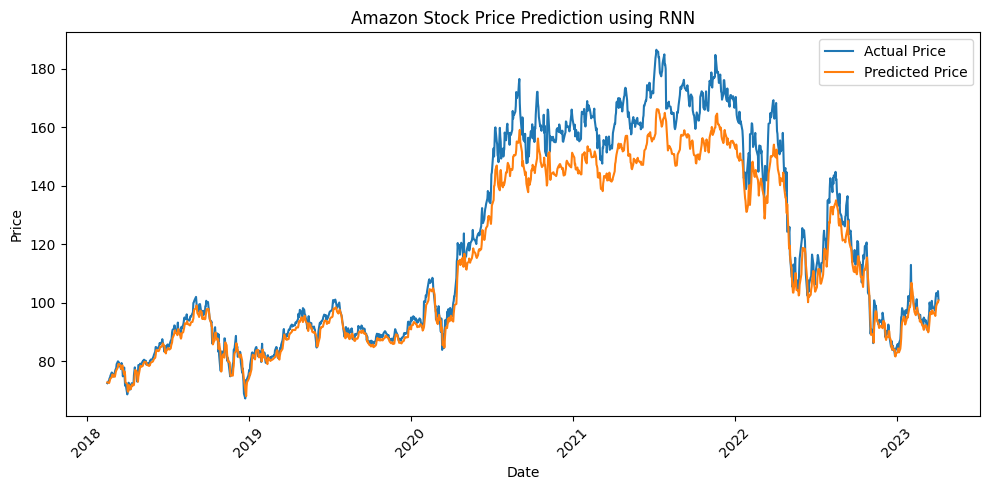

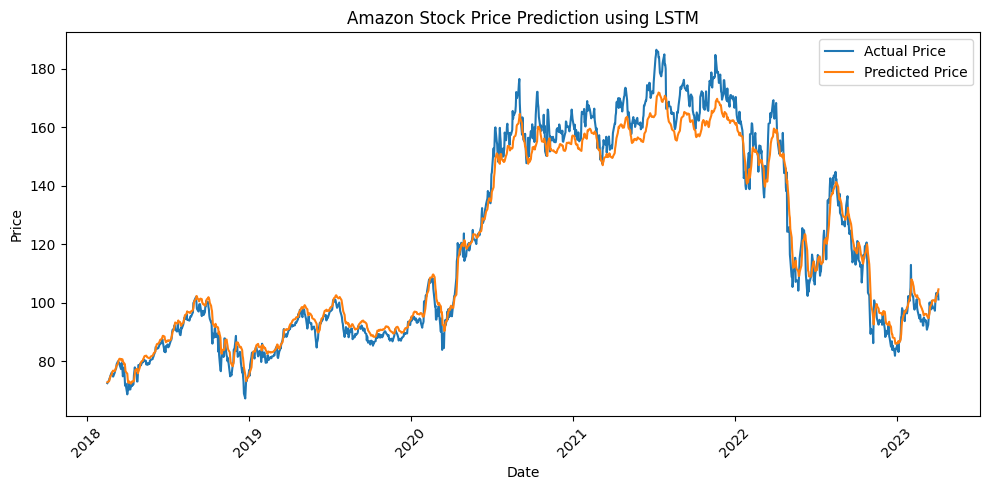

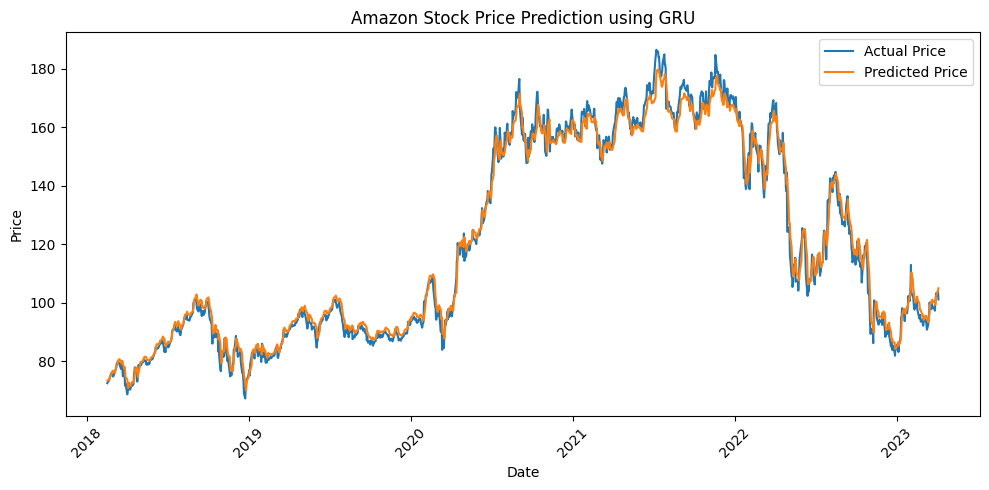

In [55]:
# ======= Plot Actual vs Predicted (Final Models) =======
for model_name, model in final_models.items():
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor).numpy()

    y_true = y_test_tensor.numpy()
    y_pred = scaler.inverse_transform(np.array(y_pred))
    y_true = scaler.inverse_transform(np.array(y_true))
        
    dates_to_plot = data['Date'].iloc[-len(y_pred):]
    plt.figure(figsize=(10,5))
    plt.plot(dates_to_plot, y_true, label='Actual Price')
    plt.plot(dates_to_plot, y_pred, label='Predicted Price')
    plt.title(f'Amazon Stock Price Prediction using {model_name}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)  # agar tanggalnya tidak saling menimpa
    plt.tight_layout()       # agar layout tidak terpotong
    plt.show()

GRU model shows the closest predicted value to the actual value in the dataset, indicating its better ability to capture the temporal patterns and dynamics of data movement compared to the other models.

# Save Model

In [ ]:
# Save model
torch.save(final_models['GRU'].state_dict(), f"model/gru.pth")

In [ ]:
# Simpan scaler
joblib.dump(scaler, 'model/scaler.pkl')